In [1]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix

In [31]:
def estimate_hitting_time(m_values, n_values, start_vertex, end_vertex, num_simulations=10):
    """
    Estimate the hitting time between two vertices in a list of lollipop graphs.

    Parameters:
    m_values (list): The list of m values, each representing the number of vertices in the complete graph part of a lollipop graph.
    n_values (list): The list of n values, each representing the number of vertices in the path part of a lollipop graph.
    start_vertex (int): The starting vertex for the random walk.
    end_vertex (int): The target vertex for the random walk.
    num_simulations (int): The number of simulations to perform.

    Returns:
    hitting_times (list): A list of estimated average hitting times for each lollipop graph.
    """

    hitting_times = []

    for m, n in zip(m_values, n_values):
        print(f'\nCalculatig hitting time for m = {m} and n={n}')
        total_steps_for_all_simulations = 0

        # Create the lollipop graph
        graph = nx.lollipop_graph(m, n)
        # print(list(graph.nodes)[-1])
        # print(end_vertex)
        # print(list(graph.nodes)[end_vertex])
        current_node = list(graph.nodes)[start_vertex]
        end_node = list(graph.nodes)[end_vertex]
        print(f'Starting node: {current_node} \t Neighbors: {list(nx.neighbors(graph,current_node))}')
        print(f'End node: {end_node} \t Neighbors: {list(nx.neighbors(graph,end_node))}')
        for s in range(num_simulations):
            if s==0 or s==1 or s==10 or s==25 or s==35 or s==49 or s==59 or s==69 or s==79 or s==89 or s==99:
                print(f'----> Sample number:{s}')
                pass
            total_steps_this_simulation = 0
            current_node = list(graph.nodes)[start_vertex]
            # Loop continues until end_vertex is reached
            while current_node != end_node:
                # Choose a neighbor randomly
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                total_steps_this_simulation += 1
                # print(current_node)
                # print(end_node)
                # print()

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_hitting_time = total_steps_for_all_simulations / num_simulations
        hitting_times.append(average_hitting_time)

    return hitting_times

def theoretical_hitting_time(n,factor,c):
    hitting_times = []
    for i in n:
        hitting_times.append(c*i**factor)
       
    return hitting_times

In [11]:
m_range = range(2, 50)
# m = 20
n_range = range(2, 50)
# n = 20
sum_range = []
samples = 100

sum_range = list(map(lambda x, y: x + y, m_range, n_range))

initVertex = 0
targetVertex = -1

factor = 2.5

hitting_times_file = f'Datasets/DynGraphsDTRW/hittingTimeLollipop_N{sum_range[-1]}_FROM{initVertex}-TO{targetVertex}_S{samples}.txt'

print(f'Looking for: \n-----> {hitting_times_file}')

if os.path.exists(hitting_times_file):
    hitting_times = load_list_from_file(hitting_times_file)
    theoretical_hitting_times = theoretical_hitting_time(sum_range,factor)
    print('\nFile exists!')
else:
    print('\nFile Doesnt Exist!')
    hitting_times = estimate_hitting_time(m_range,n_range,initVertex,targetVertex,samples)
    theoretical_hitting_times = theoretical_hitting_time(sum_range,factor)

    write_list_to_file(hitting_times_file, hitting_times)



Looking for: 
-----> Datasets/DynGraphsDTRW/hittingTimeLollipop_N98_FROM0-TO-1_S100.txt

File exists!


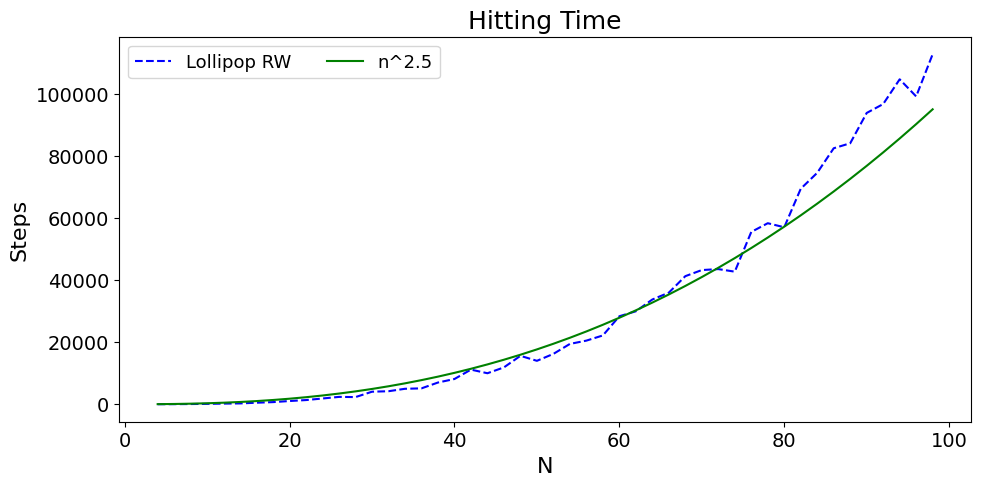

In [12]:
alphaLabelList = [r'Lollipop RW',f'n^{factor}']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(sum_range),list(sum_range)] , y_value_matrix = [hitting_times,theoretical_hitting_times],**params)

## Fitting the model

In [19]:
# Use your function to generate the DataFrame
df = pd.DataFrame({
    'n': sum_range,
    'hitting_time': hitting_times
})

# Calculate the cube root of cover_time
df['cbrt_hitting_time'] = np.cbrt(df['hitting_time'])

# Reshape data for sklearn
X = df['n'].values.reshape(-1,1)
Y = df['cbrt_hitting_time'].values.reshape(-1,1)

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, Y)

# The coefficient in the model is the estimate of c
c = model.coef_[0][0]

print('c =', c)

c = 0.4953865293097703


In [28]:

# Assume x_data and y_data are your data
x_data = sum_range
y_data = hitting_times

# Take the logarithm of your data
log_x = np.log10(x_data)
log_y = np.log10(y_data)

# Reshape your data because sklearn requires it to be in this format
log_x = log_x.reshape(-1, 1)
log_y = log_y.reshape(-1, 1)

# Create a LinearRegression object
reg = LinearRegression()

# Fit the model to your data
reg.fit(log_x, log_y)

# Now, your value of c is:
c = 10 ** reg.intercept_
print(c)

[0.12710426]


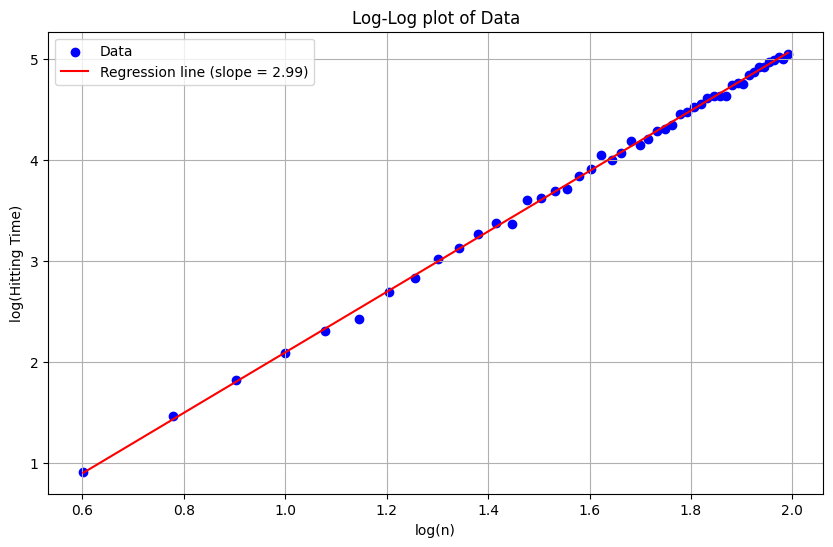

In [33]:
def plot_loglog(x_data, y_data):
    # Take the logarithm of your data
    log_x = np.log10(x_data)
    log_y = np.log10(y_data)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x, log_y, color='blue', label='Data')

    # Add a regression line
    slope, intercept = np.polyfit(log_x, log_y, 1)
    plt.plot(log_x, slope*log_x + intercept, color='red', label=f'Regression line (slope = {slope:.2f})')

    # Add labels and legend
    plt.xlabel('log(n)')
    plt.ylabel('log(Hitting Time)')
    plt.title('Log-Log plot of Data')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assume x_data and y_data are your data
plot_loglog(x_data, y_data)

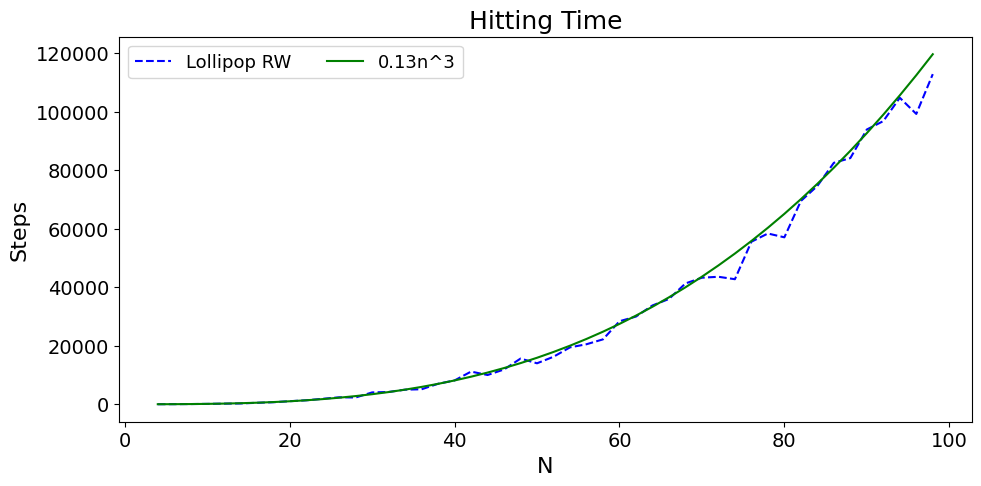

In [32]:
c = 0.12710426
factor = 3

estimate_cover_time_memory = [x for x in theoretical_hitting_time(sum_range,factor,c)]


alphaLabelList = [r'Lollipop RW',f'{round(c,2)}n^{factor}']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(sum_range),list(sum_range)] , y_value_matrix = [hitting_times,estimate_cover_time_memory],**params)

# Theoretical Hitting Time

In [61]:
def create_transition_matrix(G):
    """
    Create a Markovian transition matrix from a NetworkX graph.

    Parameters:
    G (networkx.classes.graph.Graph): A NetworkX graph.

    Returns:
    numpy.ndarray: The Markovian transition matrix.
    """
    
    # Get the adjacency matrix (A) from the graph
    A = nx.to_numpy_array(G, dtype=np.float64)
    
    # Get the sum of each row in the adjacency matrix
    row_sums = A.sum(axis=1)
    
    # Create the transition matrix (T) by dividing each row in A by the corresponding row sum
    T = np.zeros_like(A)  # Create an empty matrix with the same shape as A
    for i in range(A.shape[0]):
        T[i, :] = A[i, :] / row_sums[i]
    
    return T


In [63]:
def expected_hitting_time(P, q, z):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P.shape[0]  # Number of states

    # Create the modified transition matrix P_{-z}
    P_minus_z = P.copy()
    P_minus_z[:, z] = 0  # zero the column corresponding to z
    P_minus_z[z, :] = 0  # zero the row corresponding to z

    # Create the modified initial state distribution q_{-z}
    q_minus_z = q.copy()
    q_minus_z[z] = 0  # zero the element corresponding to z

    # Create the identity matrix
    I = np.eye(n)

    # Calculate the inverse of (I - P_{-z})
    inv = np.linalg.inv(I - P_minus_z)

    # Calculate the expected hitting time from state q to state z
    h_z_q = np.dot(q_minus_z, np.dot(inv, np.ones(n)))

    return h_z_q

def hitting_times_for_lollipop_graphs(m_values, n_values, initIndex, target):
    hitting_times = []
    for m, n in zip(m_values,n_values):
            G = nx.lollipop_graph(m, n)
            init = np.zeros(len(G))
            init[initIndex] = 1
            T = create_transition_matrix(G)
            hitting_time = expected_hitting_time(T, init, target)
            hitting_times.append(hitting_time)
    return hitting_times


In [53]:
m_range = range(2, 50)
n_range = range(2, 50)

P = create_transition_matrix(graph)

init = 0
target = -1

theoretical_hitting_times2 = hitting_times_for_lollipop_graphs(m_range, n_range, init, target)


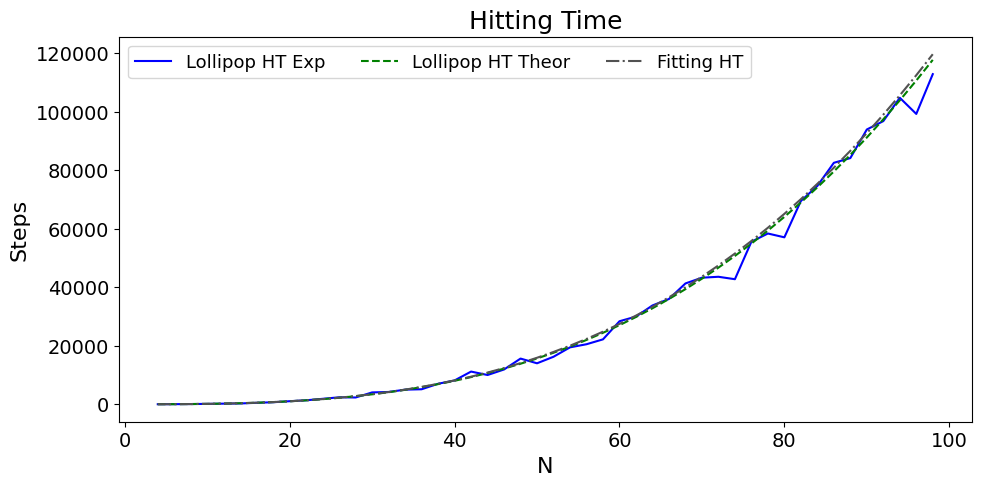

In [59]:
alphaLabelList = [r'Lollipop HT Exp',f'Lollipop HT Theor',f'Fitting HT']
c = 0.12710426
factor = 3

estimate_cover_time_memory = [x for x in theoretical_hitting_time(sum_range,factor,c)]

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['-', '--','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(sum_range),list(sum_range),list(sum_range)] , y_value_matrix = [hitting_times,theoretical_hitting_times2,estimate_cover_time_memory],**params)